In [2]:
import pandas as pd
import numpy as np
import mlforecast
import lightgbm as lgb
from matplotlib import pyplot as plt
import optuna
import plotly_express as px
import seaborn as sns
import os
import gc
import warnings
import statsmodels.api as sm

train = pd.read_parquet("../data/store_sales/train.parquet")
transactions = pd.read_parquet("../data/store_sales/transactions.parquet").sort_values(["store_nbr", "date"])
stores = pd.read_parquet("../data/store_sales/stores.parquet")
test = pd.read_parquet("../data/store_sales/test.parquet")
sub = pd.read_parquet("../data/store_sales/sample_submission.parquet")   

train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")

print(train.shape)
train = train[~((train.store_nbr == 52) & (train.date < "2017-04-20"))]
train = train[~((train.store_nbr == 22) & (train.date < "2015-10-09"))]
train = train[~((train.store_nbr == 42) & (train.date < "2015-08-21"))]
train = train[~((train.store_nbr == 21) & (train.date < "2015-07-24"))]
train = train[~((train.store_nbr == 29) & (train.date < "2015-03-20"))]
train = train[~((train.store_nbr == 20) & (train.date < "2015-02-13"))]
train = train[~((train.store_nbr == 53) & (train.date < "2014-05-29"))]
train = train[~((train.store_nbr == 36) & (train.date < "2013-05-09"))]
train.shape

print(train.shape)
# Anti Join
c = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
outer_join = train.merge(c[c.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
gc.collect()
train.shape

(3000888, 6)
(2780316, 6)


(2698648, 6)

In [3]:
holidays = pd.read_parquet("../data/store_sales/holidays_events.parquet")
holidays["date"] = pd.to_datetime(holidays.date)

# holidays[holidays.type == "Holiday"]
# holidays[(holidays.type == "Holiday") & (holidays.transferred == True)]

# Transferred Holidays
tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = pd.concat([holidays, tr]).reset_index(drop = True)


# Additional Holidays
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Bridge Holidays
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

 
# Work Day Holidays, that is meant to payback the Bridge.
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]  


# Split

# Events are national
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()



d = pd.concat([train, test]).merge(stores)
d["store_nbr"] = d["store_nbr"].astype("int8")


# National Holidays & Events
#d = pd.merge(d, events, how = "left")
d = pd.merge(d, national, how = "left")
# Regional
d = pd.merge(d, regional, how = "left", on = ["date", "state"])
# Local
d = pd.merge(d, local, how = "left", on = ["date", "city"])

# Work Day: It will be removed when real work day colum created
d = pd.merge(d,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

# EVENTS
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

events, events_cat = one_hot_encoder(events, nan_as_category=False)
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

d = pd.merge(d, events, how = "left")
d[events_cat] = d[events_cat].fillna(0)

# New features
d["holiday_national_binary"] = np.where(d.holiday_national.notnull(), 1, 0)
d["holiday_local_binary"] = np.where(d.holiday_local.notnull(), 1, 0)
d["holiday_regional_binary"] = np.where(d.holiday_regional.notnull(), 1, 0)

# 
d["national_independence"] = np.where(d.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
d["local_cantonizacio"] = np.where(d.holiday_local.str.contains("Cantonizacio"), 1, 0)
d["local_fundacion"] = np.where(d.holiday_local.str.contains("Fundacion"), 1, 0)
d["local_independencia"] = np.where(d.holiday_local.str.contains("Independencia"), 1, 0)


holidays, holidays_cat = one_hot_encoder(d[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
d = pd.concat([d.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

he_cols = d.columns[d.columns.str.startswith("events")].tolist() + d.columns[d.columns.str.startswith("holiday")].tolist() + d.columns[d.columns.str.startswith("national")].tolist()+ d.columns[d.columns.str.startswith("local")].tolist()
d[he_cols] = d[he_cols].astype("int8")

d[["family", "city", "state", "type"]] = d[["family", "city", "state", "type"]].astype("category")

del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
gc.collect()

d.head(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Quito1,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
5,8910,2013-01-06,1,AUTOMOTIVE,2.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
6,10692,2013-01-07,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
7,12474,2013-01-08,1,AUTOMOTIVE,2.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
8,14256,2013-01-09,1,AUTOMOTIVE,2.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
9,16038,2013-01-10,1,AUTOMOTIVE,2.0,0.0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Time Related Features
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    # df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df
d["date"] = pd.to_datetime(d.date)
d = create_date_features(d)




# Workday column
d["workday"] = np.where((d.holiday_national_binary == 1) | (d.holiday_local_binary==1) | (d.holiday_regional_binary==1) | (d['day_of_week'].isin([6,7])), 0, 1)
d["workday"] = pd.Series(np.where(d.IsWorkDay.notnull(), 1, d["workday"])).astype("int8")
d.drop("IsWorkDay", axis = 1, inplace = True)

# Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. 
# Supermarket sales could be affected by this.
d["wageday"] = pd.Series(np.where((d['is_month_end'] == 1) | (d["day_of_month"] == 15), 1, 0)).astype("int8")

/tmp/ipykernel_23335/655216980.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["quarter"] = df.date.dt.quarter.astype("int8")
/tmp/ipykernel_23335/655216980.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
/tmp/ipykernel_23335/655216980.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

In [5]:
new_df = d.copy()

new_df['store_family'] = new_df['store_nbr'].astype(str) + '_' + new_df['family'].astype(str)
item_sales_per_date = new_df.groupby(["date","store_family"])["sales"].aggregate("sum")
item_sales_per_date = item_sales_per_date.reset_index()
item_sales_per_date.columns = ["date","store_item","sales"]
item_sales_per_date = item_sales_per_date.sort_values("date", ascending=True)
item_sales_per_date.head()

,date,store_item,sales
0,2013-01-01,10_AUTOMOTIVE,0.0
987,2013-01-01,43_PRODUCE,0.0
986,2013-01-01,43_PREPARED FOODS,0.0
985,2013-01-01,43_POULTRY,0.0
984,2013-01-01,43_PLAYERS AND ELECTRONICS,0.0


<Axes: xlabel='date'>

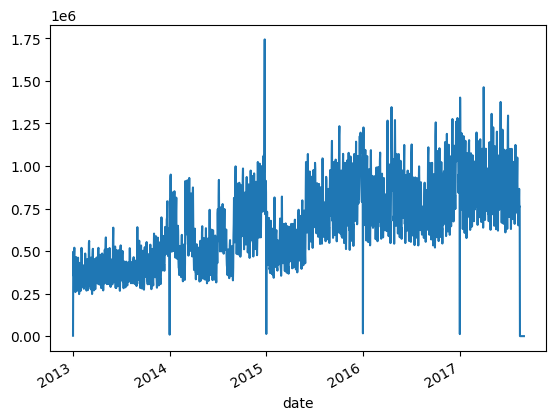

In [6]:
total_sales_per_date = item_sales_per_date.groupby(["date"])["sales"].aggregate("sum")
total_sales_per_date.plot()

In [11]:
from time import time
from statsforecast import StatsForecast
# Import necessary models from the statsforecast library
from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive,
    # Naive: A simple model that uses the last observed value as the forecast
    Naive,
    # HistoricAverage: This model uses the average of all historical data as the forecast
    HistoricAverage,
    # CrostonOptimized: A model specifically designed for intermittent demand forecasting
    CrostonOptimized,
    # ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand
    ADIDA,
    # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation
    IMAPA,
    # AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    AutoETS
)
new_df = new_df.rename(columns={"date": "ds", "sales": "y", "store_family": "unique_id"})
train = new_df[(new_df['ds'] < "2017-08-01") & (new_df['ds'] > "2013-01-01")]
valid = new_df[new_df['ds'] >= "2017-08-01"]
X_train = train.drop("y", axis = 1)
h = valid.ds.nunique()
# horizon is the number of days in the future for which we will make a forecast

# the seasonality window is 7 because we have weekly seasonality
season_length = 7
# the number of days that the model will use to make a forecast 
window_size = 6*30
models = [
    SeasonalNaive(season_length=season_length),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=season_length)
]

# Instantiate the StatsForecast class
sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq='D',  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

# Get the current time before forecasting starts, this will be used to measure the execution time
init = time()

# Call the forecast method of the StatsForecast instance to predict the next horizon days
# Level is set to [90], which means that it will compute the 90% prediction interval
fcst_df = sf.forecast(df=train, X_df=X_train, h=30, level=[90], prediction_intervals=[80, 95])

# Get the current time after the forecasting ends
end = time()

# Calculate and print the total time taken for the forecasting in minutes
print(f'Forecast Minutes: {(end - init) / 60}')

AttributeError: 'list' object has no attribute 'h'

: 